<a href="https://colab.research.google.com/github/alexandre858/DataMinig/blob/main/Projet_implemente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#Partie 1 du programme 
#Annotation et classification
import os,sys
import json
import pathlib
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plot
import numpy
import math
from sklearn.cluster import MiniBatchKMeans

try:
   os.mkdir('data')
except:
    pass


donnees={}


 
path = '.'
 
files = sorted(os.listdir(path+"/images"))


df = pd.read_csv(path+"/pokemon.csv")
df.shape

#trie et manipulation du fichier csv
#---------------------------------------------------
df2 = df.sort_values(by=['Name'], ascending=True).reset_index(drop=True)

img_name = sorted(os.listdir(path+'/images'))
img_paths = []
for i in img_name:
    img_paths.append(path + i)

df2['adresses'] = img_paths



i=1
for name in files:
  
  type1 = ""
  type2 = ""

  if os.path.isfile("images/"+name):
    
    imgfile = Image.open("images/"+name)

    #algoritme qui détermine la couleur dominante d'une image
    #---------------------------------------------------
    numarray = numpy.array(imgfile.getdata(), numpy.uint8)
    if len(numarray.shape) ==2:

      cluster_count = 5

      clusters = MiniBatchKMeans(n_clusters = cluster_count)
      clusters.fit(numarray)

      npbins = numpy.arange(0, cluster_count + 1)
      histogram = numpy.histogram(clusters.labels_, bins=npbins)




      index_max=numpy.where(histogram[0]==max(histogram[0]))

      histogram[0][index_max]=0

      index_max=numpy.where(histogram[0]==max(histogram[0]))

      histogram[0][index_max]=0

      index_max_sec=numpy.where(histogram[0]==max(histogram[0]))

      col_dom_r=math.ceil(clusters.cluster_centers_[index_max[0][0]][0])
      col_dom_g=math.ceil(clusters.cluster_centers_[index_max[0][0]][1])
      col_dom_b=math.ceil(clusters.cluster_centers_[index_max[0][0]][2])
    
    
    
    else:
      col_dom_r=500
      col_dom_g=500
      col_dom_b=500

    #---------------------------------------------------

    #découpage et assosiation des couleurs à un interavl de couleur
    #---------------------------------------------------
    list_col=[col_dom_r,col_dom_g,col_dom_b]
    interval_r=0
    interval_g=0
    interval_b=0
    list_int_col=[interval_r,interval_g,interval_b]
    inter=[range(0,32),range(32,64),range(64,96),range(96,128),range(128,160),range(160,192),range(192,224),range(224,257)]

    for i in range (0,3):

      if (list_col[i] in inter[0]):
        list_int_col[i]=0
      elif (list_col[i] in inter[1]):
        list_int_col[i]=1
      elif (list_col[i] in inter[2]):
        list_int_col[i]=2
      elif (list_col[i] in inter[3]):
        list_int_col[i]=3   
      elif (list_col[i] in inter[4]):
        list_int_col[i]=4
      elif (list_col[i] in inter[5]):
        list_int_col[i]=5
      elif (list_col[i] in inter[6]):
        list_int_col[i]=6
      elif (list_col[i] in inter[7]):
        list_int_col[i]=7
      else:
        list_int_col[i]="NaN"


    #---------------------------------------------------

    #analyse taux de présence couleurs
    #---------------------------------------------------
    histogram = imgfile.histogram()
    if (len(histogram)==1024 or len(histogram)==768):

      red = histogram[0:255]
      green = histogram[256:511]
      blue = histogram[512:767]

      total_red=0
      total_blue=0
      total_green=0

      j=0
      while j <255:
        total_red=total_red+red[j]*j
        total_blue=total_blue+blue[j]*j
        total_green=total_green+green[j]*j
        j+=1

    else:
      total_red = 0
      total_green = 0
      total_blue = 0
    #---------------------------------------------------

    #récupération des données sur le format de l'image
    #---------------------------------------------------
    hauteur=imgfile.size[0]
    largeur=imgfile.size[1]
    format=imgfile.format
    #---------------------------------------------------

    #mise en place des données dans un fichier json
    #---------------------------------------------------
    dele=4
    if (imgfile.format=="JPEG"):
      dele=5

    #mise en place des types dans un fichier json
    #---------------------------------------------------
    for index,  row in df2.iterrows():
      
      if name == row["Name"]+".png":
        type1 = row["Type1"]
        type2 = row["Type2"]  




    donnees[name]={"name":name[:-dele],"size_high":hauteur,
                    "size_lenght":largeur,"format":format,
                      "red":total_red,"green":total_green,"blue":total_blue,
                        "col_dom_r":col_dom_r,"col_dom_g":col_dom_g,"col_dom_b":col_dom_b,
                          "int_col_dom_r":list_int_col[0],"int_col_dom_g":list_int_col[1],"int_col_dom_b":list_int_col[2],
                            "Type1":type1,
                              "Type2":type2}


    i=i+1 

with open("data/data.json", "w") as file:
    json.dump(donnees, file,indent = 3)
#---------------------------------------------------







In [26]:
from collections import Counter 
#algorithme de suggestion
import json

jsondata = json.load(open('data/data_liked.json'))

moy_int_cd_r=0
moy_int_cd_g=0
moy_int_cd_b=0
Nb=0
list_type=[]
Point=0
list_all_types=[]
nb_png=0
nb_jpeg=0
mono=0

for data in jsondata:
  if (not(jsondata[data]["Type1"])in list_all_types and str(jsondata[data]["Type2"])!="nan" and jsondata[data]["Type2"]!=""):
    list_all_types.append(jsondata[data]["Type1"])
  if (not(jsondata[data]["Type2"]in list_all_types) and str(jsondata[data]["Type2"])!="nan" and jsondata[data]["Type2"]!=""):
    list_all_types.append(jsondata[data]["Type2"])
  if (jsondata[data]["liked"]==1):
    if (jsondata[data]["int_col_dom_r"]=="NaN"):
      mono+=1
    else:
      moy_int_cd_r=moy_int_cd_r+jsondata[data]["int_col_dom_r"]
      moy_int_cd_g=moy_int_cd_g+jsondata[data]["int_col_dom_g"]
      moy_int_cd_b=moy_int_cd_b+jsondata[data]["int_col_dom_b"]
    if (str(jsondata[data]["Type2"])!="nan" and jsondata[data]["Type2"]!=""):
      list_type.append(jsondata[data]["Type2"])
    if (jsondata[data]["Type1"]!=""):
      list_type.append(jsondata[data]["Type1"])
    if (jsondata[data]["format"]=="PNG"):
      nb_png+=1
    if (jsondata[data]["format"]=="JPEG"):
      nb_jpeg+=1
    Nb+=1
nb_type_list=len(list_type)
nb_png=nb_png/(nb_png+nb_jpeg)
nb_jpeg=nb_jpeg/(nb_png+nb_jpeg)
dict_type=Counter(list_type)
for i in dict_type:
  list_all_types.remove(i)
  dict_type[i]=dict_type[i]/nb_type_list
for i in list_all_types:
  dict_type[i]=0


moy_int_cd_r=round(moy_int_cd_r/Nb)
moy_int_cd_g=round(moy_int_cd_g/Nb)
moy_int_cd_b=round(moy_int_cd_b/Nb)

print(moy_int_cd_r,moy_int_cd_g,moy_int_cd_b)
point=0
for data in jsondata:
  if (jsondata[data]["liked"]=="NaN"):
    print(jsondata[data]["name"])
    if(jsondata[data]["int_col_dom_r"]=="NaN"):
      
    else:

      if (jsondata[data]["int_col_dom_r"]==moy_int_cd_r):
        point+=1

      elif (moy_int_cd_r-1<=jsondata[data]["int_col_dom_r"]<=moy_int_cd_r+1):
        point+=0.5

      if (jsondata[data]["int_col_dom_g"]==moy_int_cd_g):
        point+=1

      elif (moy_int_cd_g-1<=jsondata[data]["int_col_dom_g"]<=moy_int_cd_g+1):
        point+=0.5

      if (jsondata[data]["int_col_dom_b"]==moy_int_cd_b):
        point+=1

      elif (moy_int_cd_b-1<=jsondata[data]["int_col_dom_b"]<=moy_int_cd_b+1):
        point+=0.5

    if(jsondata[data]["format"]=="PNG"):
      point += nb_png

    if (jsondata[data]["format"]=="JPEG"):
      point += nb_jpeg



      

5 6 7
abomasnow
4
5
abra
4
absol
accelgor
2
4
aegislash-blade
2
3
aerodactyl
1
aggron
aipom
2
alakazam
4
alomomola
altaria
4
5
amaura
1
4
5
ambipom
2
amoonguss
1
4
ampharos
4
anorith
2
araquani
2
3
6
arbok
arcanine
4
6
arceus
4
5
archen
2
archeops
ariados
4
armaldo
2
aromatisse
2
aron
articuno
4
6
audino
3
6
aurorus
4
6
avalugg
2
4
6
axew
azelf
azumarill
4
5
azurill
4
5
bagon
baltoy
banette
barbaracle
barboach
basculin-red-striped
4
bastiodon
bayleef
1
3
beartic
beautifly
beedrill
4
5
beheeyem
1
beldum
bellossom
bellsprout
2
4
bergmite
bewea
bibarel
1
bidoof
binacle
bisharp
1
blacephalo
4
5
blastoise
2
4
6
blaziken
4
blissey
blitzle
boldore
bonsly
bouffalant
bounswee
4
5
braixen
2
braviary
breloom
2
4
brionn
2
4
5
bronzong
bronzor
bruxis
2
budew
2
4
buizel
4
bulbasaur
buneary
bunnelby
burmy
butterfree
4
5
buzzwol
2
cacnea
2
3
cacturne
2
4
camerupt
carbink
carnivine
2
carracosta
4
6
carvanha
2
4
cascoon
castform
caterpie
celebi
4
6
celesteel
2
4
chandelure
chansey
charizard
2
charjabu
c

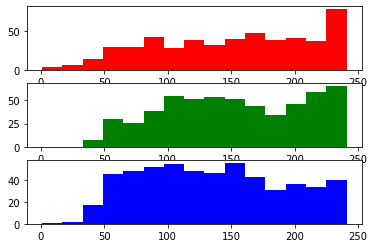

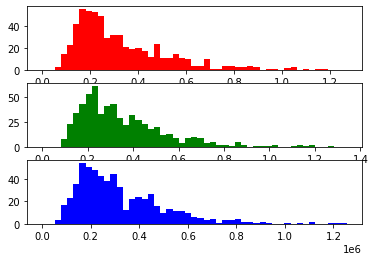

In [ ]:
#visualisation
import matplotlib.pyplot as plot
import math
import json

jsondata = json.load(open('data/data.json'))
list_col = ["col_dom_r","col_dom_g","col_dom_b","red","green","blue"]

list_dom_r=[]
list_dom_g=[]
list_dom_b=[]

list_r=[]
list_g=[]
list_b=[]

list_list=[list_dom_r,list_dom_g,list_dom_b,list_r,list_g,list_b]

for data in jsondata:

  for i in range (0,6):

    list_list[i].append(jsondata[data][list_col[i]])


fig, axs = plot.subplots(3)
axs[0].hist(list_list[0],range(1,256,16),color='red')
axs[1].hist(list_list[1],range(1,256,16),color='green')
axs[2].hist(list_list[2],range(1,256,16),color='blue')
plot.show()
fig, axes = plot.subplots(3)
axes[0].hist(list_list[3],range(1,max(list_list[3]),math.ceil((max(list_list[3])-min(list_list[3]))/50)),color='red')
axes[1].hist(list_list[4],range(1,max(list_list[4]),math.ceil((max(list_list[4])-min(list_list[4]))/50)),color='green')
axes[2].hist(list_list[5],range(1,max(list_list[5]),math.ceil((max(list_list[5])-min(list_list[5]))/50)),color='blue')
plot.show()

In [ ]:
#test découpage couleur

import os,sys
from PIL import Image
import numpy
import math
import matplotlib.pyplot as plot
from sklearn.cluster import MiniBatchKMeans


path = '.'
 
files = os.listdir(path+"/images_test")

i=1
for name in files:
  if os.path.isfile("images_test/"+name):
    imgfile = Image.open("images_test/"+name)
    #numarray=numpy.zeros((imgfile.size[0]*imgfile.size[1],4))
    numarray = numpy.array(imgfile.getdata(), numpy.uint8)
    if (len(numarray.shape)==2):




      cluster_count = 4
      clusters = MiniBatchKMeans(n_clusters = cluster_count)

      clusters.fit(numarray)

      npbins = numpy.arange(0, cluster_count+1 )
      histogram = numpy.histogram(clusters.labels_, bins=npbins)

      index_max=numpy.where(histogram[0]==max(histogram[0]))

      #print(histogram[0],index_max)

      histogram[0][index_max]=0

      index_max=numpy.where(histogram[0]==max(histogram[0]))


      #print(histogram[0],index_max)


    #print(histogram[0],index_max_sec)

    #print(clusters.cluster_centers_,index_max)

      col_dom_r = math.ceil(clusters.cluster_centers_[index_max[0][0]][0])
      col_dom_g = math.ceil(clusters.cluster_centers_[index_max[0][0]][1]) 
      col_dom_b = math.ceil(clusters.cluster_centers_[index_max[0][0]][2]) 
    else:
      col_dom_r =500
      col_dom_g =500
      col_dom_b =500

    list_col=[col_dom_r,col_dom_g,col_dom_b]
    interval_r=0
    interval_g=0
    interval_b=0
    list_int_col=[interval_r,interval_g,interval_b]
    inter=[range(0,32),range(32,64),range(64,96),range(96,128),range(128,160),range(160,192),range(192,224),range(224,256)]

    for i in range (0,3):

      if (list_col[i] in inter[0]):
        list_int_col[i]=0
      elif (list_col[i] in inter[1]):
        list_int_col[i]=1
      elif (list_col[i] in inter[2]):
        list_int_col[i]=2
      elif (list_col[i] in inter[3]):
        list_int_col[i]=3   
      elif (list_col[i] in inter[4]):
        list_int_col[i]=4
      elif (list_col[i] in inter[5]):
        list_int_col[i]=5
      elif (list_col[i] in inter[6]):
        list_int_col[i]=6
      elif (list_col[i] in inter[7]):
        list_int_col[i]=7
      else:
        list_int_col[i]="NaN"
    print(list_col,list_int_col)


FileNotFoundError: ignored

In [ ]:
#test taux de presence
from PIL import Image
import matplotlib.pyplot as plot

path = '.'
 
files = os.listdir(path+"/images_test")

for name in files:
  if os.path.isfile("images_test/"+name):

imgfile = Image.open("./images/archeops.png")


histogram = imgfile.histogram()
# we have three bands (for this image)
red = histogram[0:255]
green = histogram[256:511]
blue = histogram[512:767]

total_red=0
total_blue=0
total_green=0

i=0
while i <255:
  total_red=total_red+red[i]*i
  total_blue=total_blue+blue[i]*i
  total_green=total_green+green[i]*i
  i+=1


print(total_red,total_blue,total_green)





 

IndentationError: ignored

In [15]:
#algorithme like image
from PIL import Image
import matplotlib.pyplot as plot
import matplotlib.image as mpimg
import json
from random import seed,random

manual_choice=False
nb_image_to_like=5
seed(2)
try:
   os.mkdir('data')
except:
    pass

path='.'
files = os.listdir(path+"/images")

#database
jsondata = json.load(open('data/data.json'))

donnees=jsondata
with open("data/data_liked.json", "w") as file:
    json.dump(donnees, file,indent = 3)

i=0
for name in files:
  if os.path.isfile("images/"+name):

    if (i<nb_image_to_like):

      if (manual_choice):

        img = mpimg.imread("images/"+name)
        imgplot = plot.imshow(img)
        plot.show()

        n=int(input("Entrez 1 si vous aimez, ou 0 si non : "))
        jsondata[name]["liked"]=n

        i=i+1

      else:

        n=round(random())
        jsondata[name]["liked"]=n
        i=i+1

    else:
      jsondata[name]["liked"]="NaN"

donnees=jsondata
with open("data/data_liked.json", "w") as file:
    json.dump(donnees, file,indent = 3)

In [ ]:
#test kmeans
import os,sys
from PIL import Image
import numpy
import math
import matplotlib.pyplot as plot
from sklearn.cluster import MiniBatchKMeans


path = '.'
 
files = os.listdir(path+"/images_test")

i=1
for name in files:
  if os.path.isfile("images_test/"+name):
    imgfile = Image.open("images_test/"+name)
    #numarray=numpy.zeros((imgfile.size[0]*imgfile.size[1],4))
    numarray = numpy.array(imgfile.getdata(), numpy.uint8)
    if (len(numarray.shape)==2):




      cluster_count = 4
      clusters = MiniBatchKMeans(n_clusters = cluster_count)

      clusters.fit(numarray)

      npbins = numpy.arange(0, cluster_count+1 )
      histogram = numpy.histogram(clusters.labels_, bins=npbins)

      index_max=numpy.where(histogram[0]==max(histogram[0]))

      #print(histogram[0],index_max)

      histogram[0][index_max]=0

      index_max=numpy.where(histogram[0]==max(histogram[0]))


      #print(histogram[0],index_max)


    #print(histogram[0],index_max_sec)

    #print(clusters.cluster_centers_,index_max)

      col_dom_r = math.ceil(clusters.cluster_centers_[index_max[0][0]][0])
      col_dom_g = math.ceil(clusters.cluster_centers_[index_max[0][0]][1]) 
      col_dom_b = math.ceil(clusters.cluster_centers_[index_max[0][0]][2]) 
      
      



FileNotFoundError: ignored